In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

/var/folders/nd/6ht4mmls0gzg729_dynkxc340000gn/T/ipykernel_67350/2447193.py:1: DtypeWarning: Columns (56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Merged_WB_PWT_DEMO.csv", encoding="utf-8-sig")
/var/folders/nd/6ht4mmls0gzg729_dynkxc340000gn/T/ipykernel_67350/2447193.py:23: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  wb_wide.groupby("country")["gdp_pc"].pct_change() * 100
/var/folders/nd/6ht4mmls0gzg729_dynkxc340000gn/T/ipykernel_67350/2447193.py:40: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pwt_panel.groupby("c


=== Lasso Regression (GDP per capita growth) ===
RMSE: 4.889
R²:   0.035
MAPE: 1114.19%

=== Lasso Coefficients ===
           feature  coefficient
11             pop     0.571079
8   trade_openness     0.309181
1               pv     0.285181
0               va     0.000000
2               ge    -0.000000
3               rq    -0.000000
7        education    -0.000000
9            rgdpe    -0.000000
10           rgdpo    -0.000000
4               rl    -0.091014
5               cc    -0.277836
6       pop_growth    -0.369313


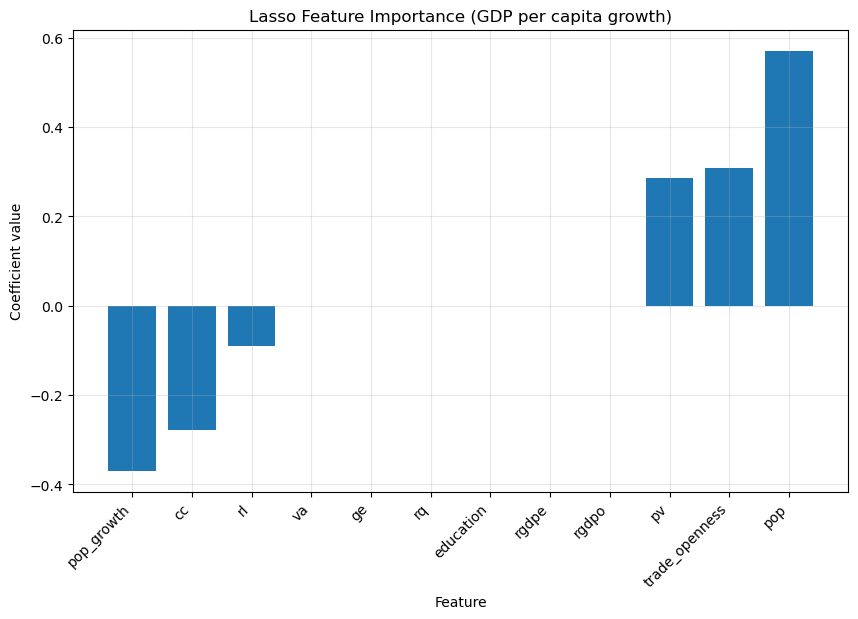


=== Predicted Fastest-growing Countries Since 2010 ===
country
China         6.129425
India         5.693610
Singapore     3.206199
Luxembourg    3.034074
Hungary       2.939605
Viet Nam      2.849917
Bulgaria      2.824372
Lithuania     2.791576
Ukraine       2.724200
Latvia        2.682972
Name: pred_gdp_pc_growth, dtype: float64


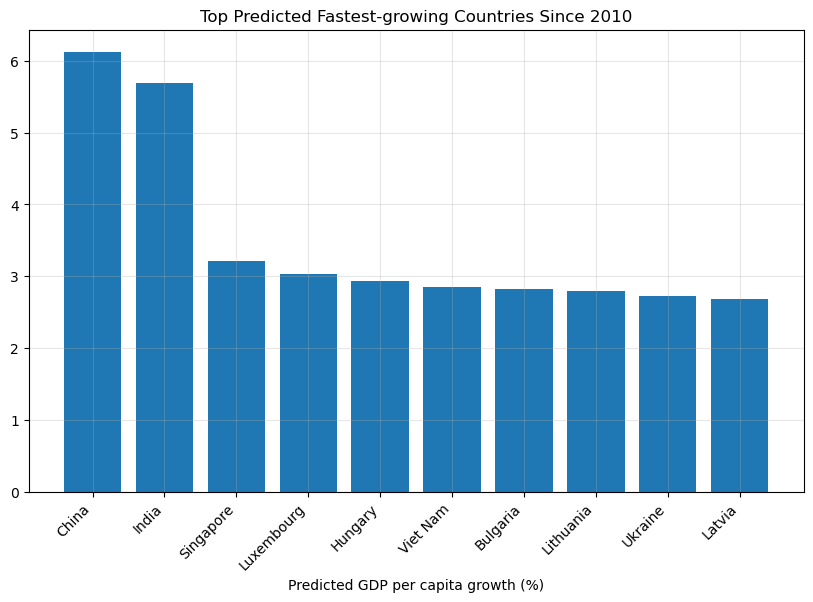

In [2]:
df = pd.read_csv("Merged_WB_PWT_DEMO.csv", encoding="utf-8-sig")
df.columns = [c.lower().strip().replace(" ", "_") for c in df.columns]
df = df.replace('..', np.nan)
wb_wide = df.pivot_table(
    index=["country", "year"],
    columns="series_code",
    values="wb_value",
    aggfunc="first"
).reset_index()
wb_rename = {
    "NY.GDP.PCAP.KD": "gdp_pc",
    "NE.TRD.GNFS.ZS": "trade_openness",
    "FP.CPI.TOTL.ZG": "inflation",
    "BX.KLT.DINV.WD.GD.ZS": "FDI",
    "NE.GDI.TOTL.ZS": "investment_ratio"
}

wb_wide = wb_wide.rename(columns={k: v for k, v in wb_rename.items() if k in wb_wide.columns})
if "gdp_pc" in wb_wide.columns:
    wb_wide["gdp_pc"] = pd.to_numeric(wb_wide["gdp_pc"], errors="coerce")
    wb_wide = wb_wide.sort_values(["country", "year"])
    wb_wide["gdp_pc_growth"] = (
        wb_wide.groupby("country")["gdp_pc"].pct_change() * 100
    )

base_cols = [
    "country", "country_code", "series_name", "series_code",
    "year", "wb_value", "countrycode", "currency_unit",
    "demographic_indicator", "unnamed:_3", "unnamed:_4",
    "unnamed:_5", "unnamed:_6"
]

base_cols = [c for c in base_cols if c in df.columns]
pwt_cols = [c for c in df.columns if c not in base_cols]
pwt_panel = df.groupby(["country", "year"], as_index=False)[pwt_cols].first()

if "pop" in pwt_panel.columns:
    pwt_panel = pwt_panel.sort_values(["country", "year"])
    pwt_panel["pop_growth"] = (
        pwt_panel.groupby("country")["pop"].pct_change() * 100
    )
if "hc" in pwt_panel.columns:
    pwt_panel = pwt_panel.rename(columns={"hc": "education"})


wgi = pd.read_excel("wgidataset.xlsx")
wgi.columns = [c.lower().strip() for c in wgi.columns]
wgi = wgi.rename(columns={"countryname": "country"})
wgi["estimate"] = pd.to_numeric(wgi["estimate"], errors="coerce")

wgi_pivot = wgi.pivot_table(
    index=["country", "year"],
    columns="indicator",
    values="estimate",
    aggfunc="mean"
).reset_index()

panel = wb_wide.merge(pwt_panel, on=["country", "year"], how="left") \
               .merge(wgi_pivot, on=["country", "year"], how="left")

target = "gdp_pc_growth"

candidate_features = [
    # Governance
    "va", "pv", "ge", "rq", "rl", "cc",
    "pop_growth", "education",
    "trade_openness", "inflation", "FDI", "investment_ratio",
    "rgdpe", "rgdpo", "pop"
]

features = [f for f in candidate_features if f in panel.columns]
model_df = panel.dropna(subset=[target]).copy()
model_df = model_df.replace('..', np.nan)

for col in features + [target]:
    model_df[col] = pd.to_numeric(model_df[col], errors='coerce')

model_df = model_df.dropna(subset=features + [target])

X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = linear_model.Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

y_pred = lasso.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


print("\n=== Lasso Regression (GDP per capita growth) ===")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")
print(f"MAPE: {mape:.2f}%")

coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": lasso.coef_
}).sort_values("coefficient", ascending=False)

print("\n=== Lasso Coefficients ===")
print(coef_df)

coef_df_sorted = coef_df.sort_values("coefficient", ascending=True)
plt.figure(figsize=(10, 6))
plt.bar(
    x=range(len(coef_df_sorted)),
    height=coef_df_sorted["coefficient"],
    tick_label=coef_df_sorted["feature"]
)
plt.title("Lasso Feature Importance (GDP per capita growth)")
plt.xlabel("Feature")
plt.ylabel("Coefficient value")
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.show()



model_df["pred_gdp_pc_growth"] = lasso.predict(scaler.transform(model_df[features]))
recent = model_df[model_df["year"] >= 2010]
rank = recent.groupby("country")["pred_gdp_pc_growth"].mean().sort_values(ascending=False)
print("\n=== Predicted Fastest-growing Countries Since 2010 ===")
print(rank.head(10))

top_countries = rank.head(10)
plt.figure(figsize=(10, 6))
plt.bar(
    x=range(len(top_countries)),
    height=top_countries.values,
    tick_label=top_countries.index
       )
plt.xlabel("Predicted GDP per capita growth (%)")
plt.title("Top Predicted Fastest-growing Countries Since 2010")
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.show()